In [1]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 15.1.1 Generate 100 random samples

In [2]:
def gen_random(n=100):
    means = [20, 5]
    covs = [[2, 0.8], [0.8, 0.5]]
    return pd.DataFrame(stats.multivariate_normal.rvs(means, covs, size=n), columns=['ut', 'uc'])

In [3]:
rand_data = gen_random()

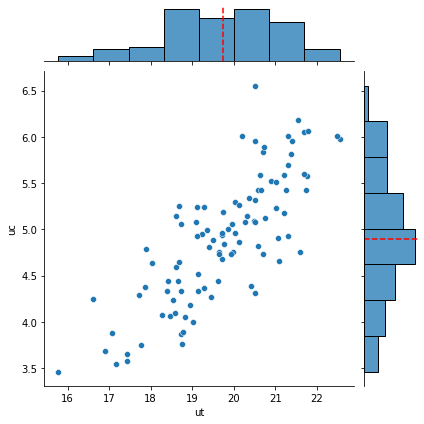

In [4]:
g = sns.jointplot(data=rand_data, x='ut', y='uc') 
g.ax_marg_x.axvline(rand_data.ut.mean(), color='r', linestyle='--')
g.ax_marg_y.axhline(rand_data.uc.mean(), color='r', linestyle='--')

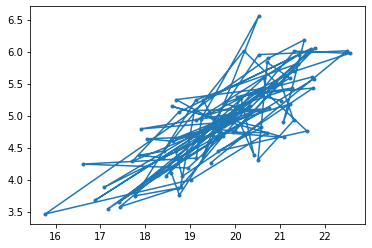

In [5]:
plt.plot(rand_data.ut, rand_data.uc, '.-')

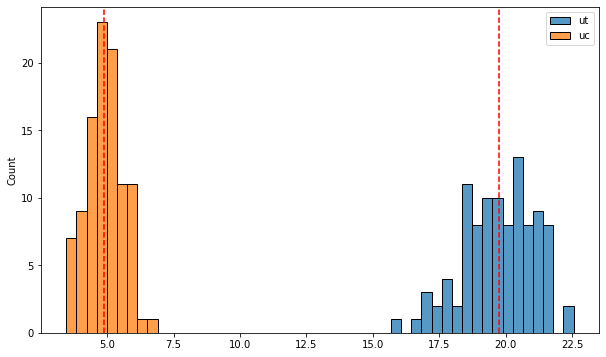

In [6]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(rand_data, bins=50, stat='count')
ax.axvline(rand_data.ut.mean(), color='r', linestyle='--')
ax.axvline(rand_data.uc.mean(), color='r', linestyle='--')

### 15.1.2 Code up a Random Walk Metropolis sampler

In [7]:
def propose_step(current):
    return stats.multivariate_normal.rvs(current)

In [8]:
def calc_ratio(current, proposed):
    p_current = stats.multivariate_normal.pdf(current, mean=[20, 5], cov=[[2, 0.8], [0.8, 0.5]])
    p_proposed = stats.multivariate_normal.pdf(proposed, mean=[20, 5], cov=[[2, 0.8], [0.8, 0.5]])
    return p_proposed/p_current

In [9]:
def get_next_value(current):
    proposed = propose_step(current)
    ratio = calc_ratio(current, proposed)
    u = stats.uniform.rvs()
    if ratio > u:
        return proposed, 1
    return current, 0

In [10]:
def RWMetropolis(start, n):
    results = [start]
    num_accepted = 0
    for _ in range(n):
        next_step, accepted = get_next_value(results[-1])
        results.append(next_step)
        num_accepted += accepted
    stats = {'steps': n, 'acc_steps': num_accepted, 'perc_accepted': num_accepted/n}
    return pd.DataFrame(results, columns=['ut', 'uc']), stats

In [11]:
rmw_data, rmw_stats = RWMetropolis((10, 5), 100)

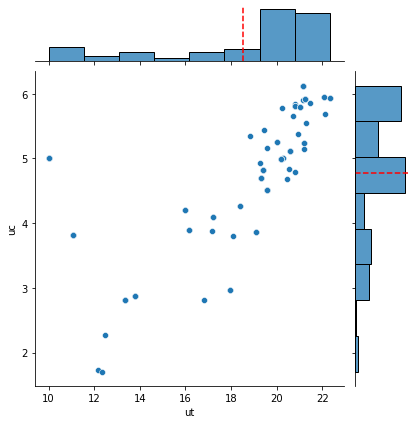

In [12]:
g = sns.jointplot(data=rmw_data, x='ut', y='uc') 
g.ax_marg_x.axvline(rmw_data.ut.mean(), color='r', linestyle='--')
g.ax_marg_y.axhline(rmw_data.uc.mean(), color='r', linestyle='--')

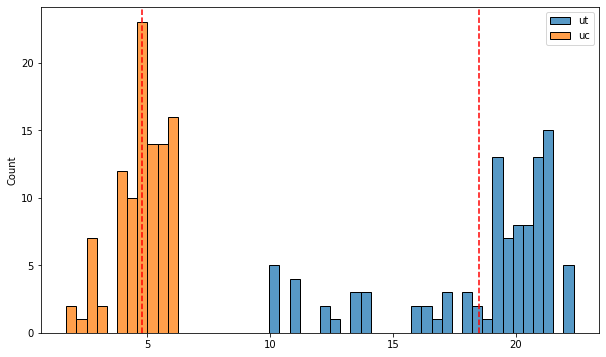

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(rmw_data, bins=50, stat='count')
ax.axvline(rmw_data.ut.mean(), color='r', linestyle='--')
ax.axvline(rmw_data.uc.mean(), color='r', linestyle='--')

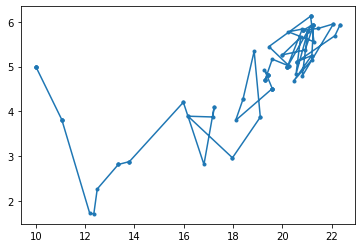

In [14]:
plt.plot(rmw_data.ut, rmw_data.uc, '.-')

### 15.1.3 Code up a Random Walk Metropolis sampler

In [15]:
rmw_stats

{'steps': 100, 'acc_steps': 45, 'perc_accepted': 0.45}

### 15.1.4 Calculate Gelman's R

In [16]:
def calc_W(chains):
    '''Calculate within chain variance'''
    # chains is list of lists at the moment
    return np.mean([np.var(c, ddof=1) for c in chains])

In [17]:
def calc_B(chains):
    '''Calculate between chain variance'''
    # chains is list of lists at the moment
    glob_mean = np.mean(chains)
    chain_means = [np.mean(c) for c in chains]
    n_chains = len(chains)
    t = len(chains[0])
    return np.sum((chain_means-glob_mean)**2)*t/(n_chains-1)

In [18]:
def calc_R(chains):
    B = calc_B(chains)
    W = calc_W(chains)
    T = len(chains[0])
#     print(B, W, T)
    return np.sqrt((W + (B-W)/T)/W)

### 15.1.5 Start 8 chains at (20,5) with lengh of 5 and calc R

In [19]:
def RWMetropolis_chains(n_chains, l_chain, start_init):
    chains = [RWMetropolis(start_init(), l_chain)[0] for _ in range(n_chains)]
    R_ut = calc_R([c.ut for c in chains])
    R_uc = calc_R([c.uc for c in chains])
    return R_ut, R_uc, chains

In [20]:
def constant_initializer():
    return (20, 5)

In [34]:
R_ut, R_uc, chains = RWMetropolis_chains(8, 5, constant_initializer)

In [32]:
def chains_plot(chains):
    N = len(chains[0].ut)
    R_uts = [calc_R([c.ut[:i] for c in chains]) for i in range(N+1)]
    R_ucs = [calc_R([c.uc[:i] for c in chains]) for i in range(N+1)]
    
    f, ax = plt.subplots(2, 2, figsize=(12,10))
    ax[0][0].plot(list(zip(*[c.ut for c in chains])), '.-')
    ax[0][0].set_title(f'ut ($\hat{{R}}$={R_uts[-1]:.3})')
    ax[0][0].set_ylim((0, 35))
    ax[0][1].plot(list(zip(*[c.uc for c in chains])), '.-')
    ax[0][1].set_title(f'uc ($\hat{{R}}$={R_ucs[-1]:.3})')
    ax[0][1].set_ylim((0, 9))
    
    ax[1][0].plot(R_uts)
    ax[1][1].plot(R_ucs)
    for a in ax[1]:
        a.set_ylim([0, 4])
        a.axhline(1.1, color='r')
        
    uts_conv = np.argmax(np.array(R_uts)<1.1)
    ucs_conv = np.argmax(np.array(R_ucs)<1.1)
    
    ax[1][0].axvline(uts_conv, color='g')
    ax[1][1].axvline(ucs_conv, color='g')
    ax[1][0].set_title(f'converged at {uts_conv}')
    ax[1][1].set_title(f'converged at {ucs_conv}')

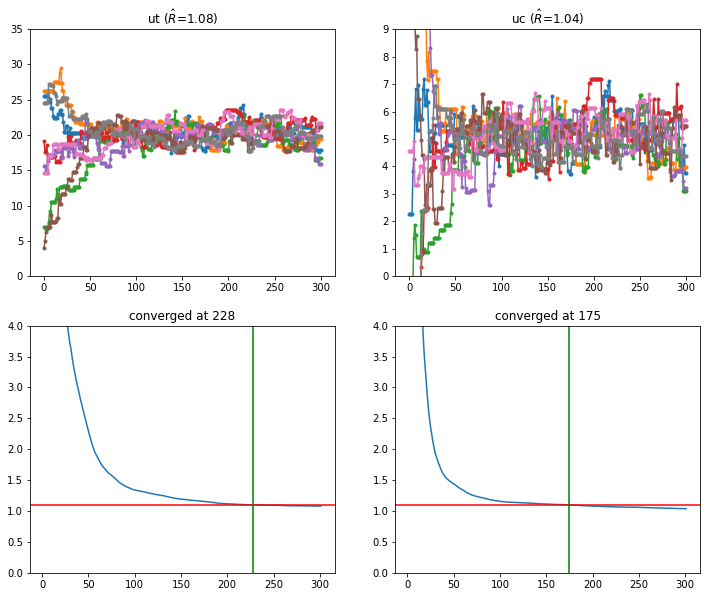

In [33]:
a = chains_plot(chains)

### 15.1.6 Start 8 chains at random locations and length 100

In [27]:
def random_initializer():
    means = [20, 5]
    covs = np.identity(2)*40
    return stats.multivariate_normal.rvs(means, covs, size=1)

In [39]:
R_ut, R_uc, chains = RWMetropolis_chains(8, 300, random_initializer)

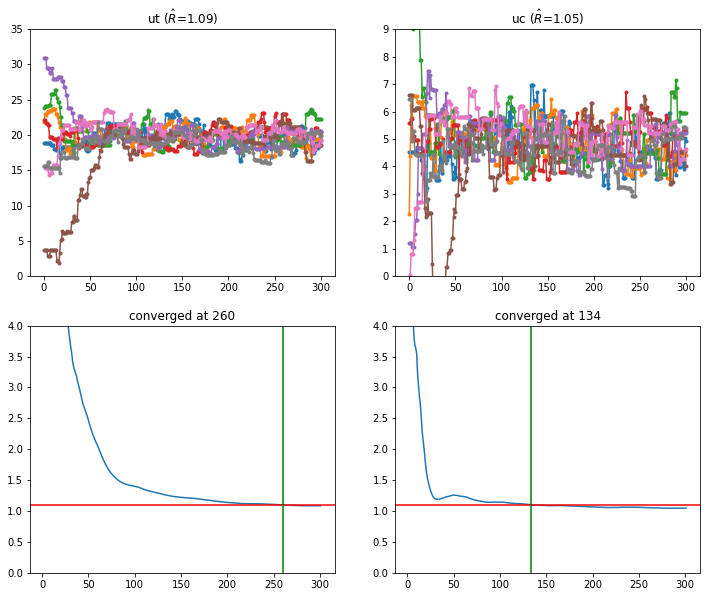

In [40]:
chains_plot(chains)

### 15.1.7 After how many iterations converged?

Convergence marked in green in above plots; it tooks about 250 iterations for ut and 150 for uc